<a href="https://colab.research.google.com/github/jon-nowacki/Optimization-Models/blob/main/Supply_Chain_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Module 6
---
In this notebook, we will use the Pyomo framework in Python to solve optimization problems related to manufacturing, and show how to use networkX with Pyomo. Additionally, we will demonstrate how to create simulations for modeling dynamic systems.

# Install & Import Frameworks

### Install
* Pyomo
* glpk solver

In [2]:
!pip install -q pyomo > /dev/null
!apt-get install -y -qq glpk-utils > /dev/null

**Importing libraries**

In [3]:
#pyomo framework
import numpy as np
from pyomo.environ import *
import pyomo.environ as pyo
from pyomo.opt import SolverFactory

#networkx framework
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,3)

import pandas as pd
import numpy as np
import random

# visualization frameworks
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# Manufacturing optimization

In [28]:
'''
time_step: an integer to track the current time step
dc_capacities: list of distribution center capacities for time step
customer_demands: list of the demand per customer per time step
cost_per_mile: $/mile used to calculate the total cost
'''

def transportation_optimization(time_step, dc_capacities, customer_demands, cost_per_mile):



  # create model
  model=ConcreteModel(name='Supply Chain Simulation')

  # define variables
  # distribution centers
  model.distribution_centers = Set(initialize=["D1","D2","D3"], doc="distribution centers")
  model.customers = Set(initialize=["C1","C2"], doc="customers")


  # definint_parameters
  model.distribution_capacity = Param(model.distribution_centers,
                                      initialize={"D1":dc_capacities[0],
                                                  "D2": dc_capacities[1],
                                                  "D3": dc_capacities[2]},
                                      doc="capacities of each distribution center")
  model.cust_demand = Param(model.customers, initialize={"C1":30, "C2":40}, doc="demand for each customer")

  dist={
      ("D1", "C1") : 1,
      ("D2", "C1") : 1,
      ("D3", "C1") : 3,
      ("D1", "C2") : 2,
      ("D2", "C2") : 1,
      ("D3", "C2") : 2,
  }
  # define objective

  model.distance = Param(model.distribution_centers, model.customers, initialize=dist, doc="distance in mile between centers and customers")

  model.distribution_cost=Param(initialize=cost_per_mile, doc="distribution cost per mile")

  model.shipment_quantity = Var(model.distribution_centers, model.customers, domain=NonNegativeIntegers, doc="quantitity shipped between dc and customer")

  def transportation_cost(model, dc, customer):
    return model.distribution_cost * model.distance[dc, customer]

  model.distance_cost = Param(model.distribution_centers, model.customers, rule=transportation_cost, doc="distribution cost per mile")

  # solve

  def supply_limit(model, dc):
    return sum(model.shipment_quantity[dc, customer] for customer in model.customers) <= model.distribution_capacity[dc]

  model.supply = Constraint(model.distribution_centers, rule=supply_limit, doc="customer demand list constraint")


  def demand_limit(model, customer):
    return sum(model.shipment_quantity[dc, customer] for dc in model.distribution_centers) >= model.cust_demand[customer]

  model.demand = Constraint(model.customers, rule=demand_limit, doc="customer demand list constraint")

  def objective_rule(model):
    return sum(model.distance_cost[dc, customer]*model.shipment_quantity[dc, customer] for dc in model.distribution_centers for customer in model.customers)

  model.objective = Objective(rule=objective_rule, sense=minimize, doc="asdf")

  SolverFactory('glpk',executable='/usr/bin/glpsol').solve(model) #.write() # Deactivate .write() by default

  # display results
  # model.shipment_quantity.display()

  def get_shipment_quantities():
    # list of distribution center capacities at end of each time step
    dc_utilizations = []

    # list that tracks the amount shipped between a distribution center and customer
    supplier_log = []

    # look through each distribution center and count how many shipments are made
    for dc in model.distribution_centers:
      # total number of shipments from center i
      total_shipments = 0

      # loop through each customer and count the number of shipments to customer j, from distribution center i
      for customer in model.customers:
        total_shipments = total_shipments + model.shipment_quantity[dc, customer].value

        # if the model shows the distributionn center ships to customer, then log that relationship in the supplier log
        if model.shipment_quantity[dc, customer].value > 0:
          supplier_log.append([time_step, customer, dc,  model.shipment_quantity[dc, customer].value])

      # calculate the capacity utilization for distribution center i
      utilization = total_shipments / model.distribution_capacity[dc]

      dc_utilizations.append(utilization)

    return dc_utilizations, supplier_log

  # Returns 1) .... 2) ....
  dc_util, supplier_log = get_shipment_quantities()
  return dc_util, supplier_log





### Test the Function

In [29]:
c_demand = [30, 40]
dc_capacity = [20, 40, 50]
utilization, a_log = transportation_optimization(0, dc_capacity, c_demand, 10)
print("utilization", utilization)
print("supplier log", a_log)


utilization [1.0, 1.0, 0.2]
supplier log [[0, 'C1', 'D1', 20.0], [0, 'C1', 'D2', 10.0], [0, 'C2', 'D2', 30.0], [0, 'C2', 'D3', 10.0]]


### Time-Series Parameters

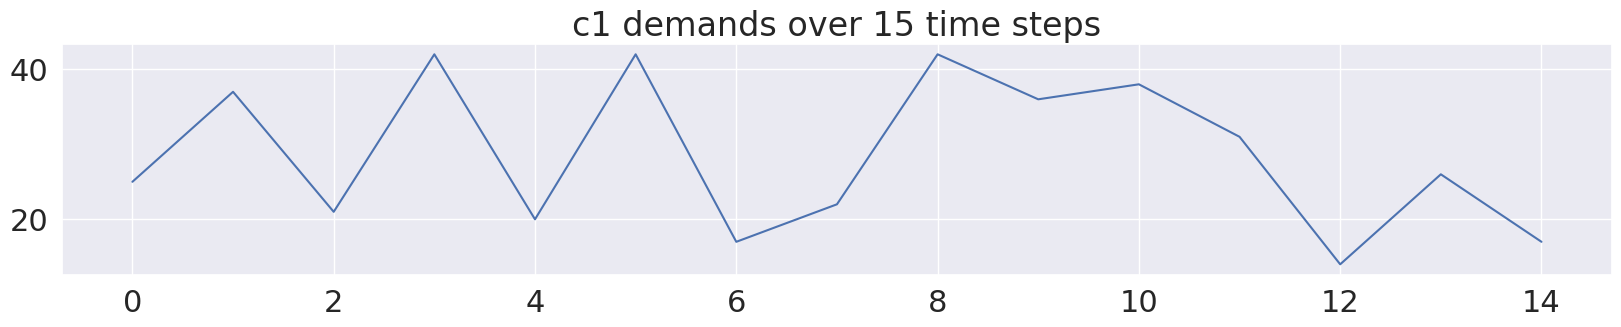

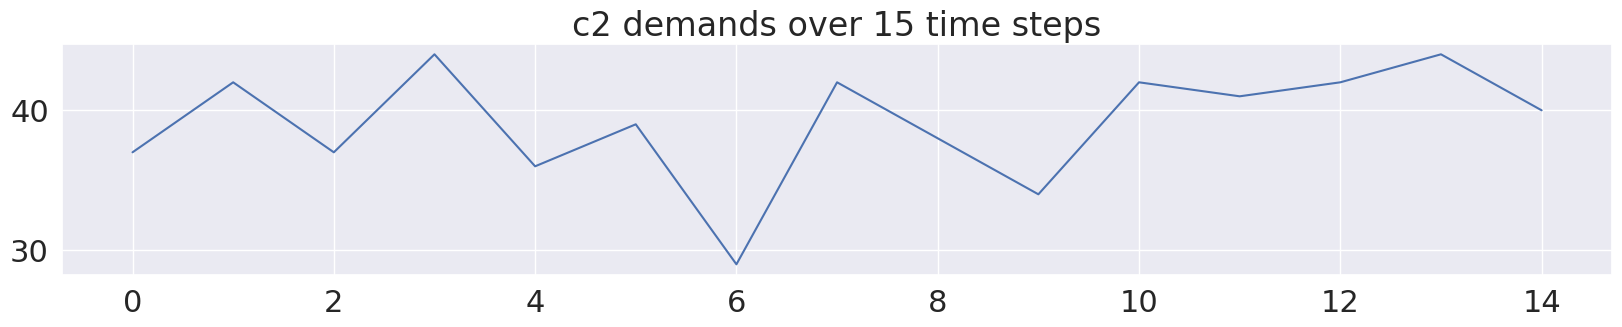

In [48]:
time_steps = 15
'''
mean: mean of the distribution
std: standard deviation of distribution
total_timesteps: total number of random numbers to generate
'''

def gen_demands(mean, std, total_timesteps):
  demands = []
  for i in range(total_timesteps):
    demand = int(round(random.gauss(mean, std)))
    demands.append(demand)
  return demands

c1demands = gen_demands(30, 10, time_steps) # mean, std, time steps
plt.plot(c1demands)
plt.title("c1 demands over 15 time steps")
plt.show()

c2demands = gen_demands(40, 5, time_steps) # mean, std, time steps
plt.plot(c2demands)
plt.title("c2 demands over 15 time steps")
plt.show()

### Optimization Function with Time-Series Parameters

In [58]:
# list of max capacities for each distribution center
dc_max_capacities=[20,40,50]

df_capacity_utilization = pd.DataFrame(index=["D1", "D2", "D3"])

# dataframe for tracking the distribution of product between customers and distribution centers
df_time_log=pd.DataFrame(columns=["time", "customer","distribution center", "qty"])

# simulatino loop
for t in range(time_steps):
  customer_demand=[c1demands[t], c2demands[t]]
  dc_util, supplier_log = transportation_optimization(t, dc_max_capacities, customer_demand, 10)
  df_capacity_utilization[str(t)] = dc_util
  supplier_log_df=pd.DataFrame(supplier_log, columns=["time", "customer","distribution center", "qty"])
  df_time_log=pd.concat([df_time_log, supplier_log_df])

df_time_log.reset_index(inplace=True)

print(df_time_log)

    index time customer distribution center   qty
0       0    0       C1                  D1  20.0
1       1    0       C1                  D2  10.0
2       2    0       C2                  D2  30.0
3       3    0       C2                  D3  10.0
4       0    1       C1                  D1  20.0
5       1    1       C1                  D2  10.0
6       2    1       C2                  D2  30.0
7       3    1       C2                  D3  10.0
8       0    2       C1                  D1  20.0
9       1    2       C1                  D2  10.0
10      2    2       C2                  D2  30.0
11      3    2       C2                  D3  10.0
12      0    3       C1                  D1  20.0
13      1    3       C1                  D2  10.0
14      2    3       C2                  D2  30.0
15      3    3       C2                  D3  10.0
16      0    4       C1                  D1  20.0
17      1    4       C1                  D2  10.0
18      2    4       C2                  D2  30.0


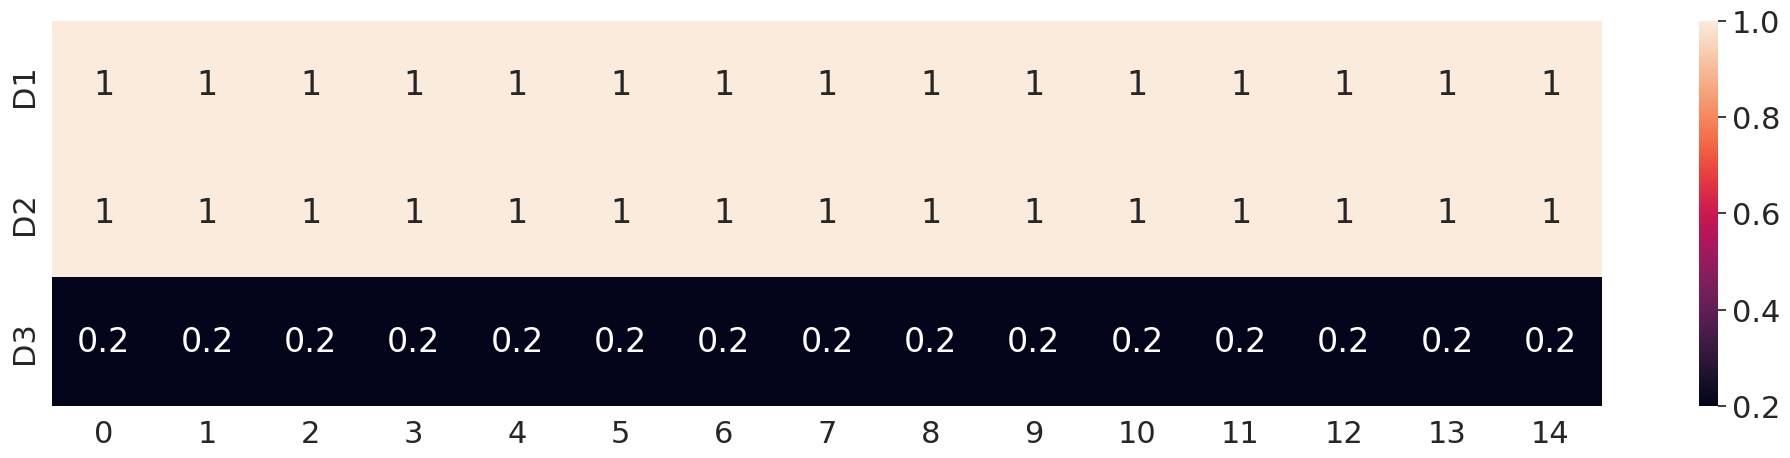

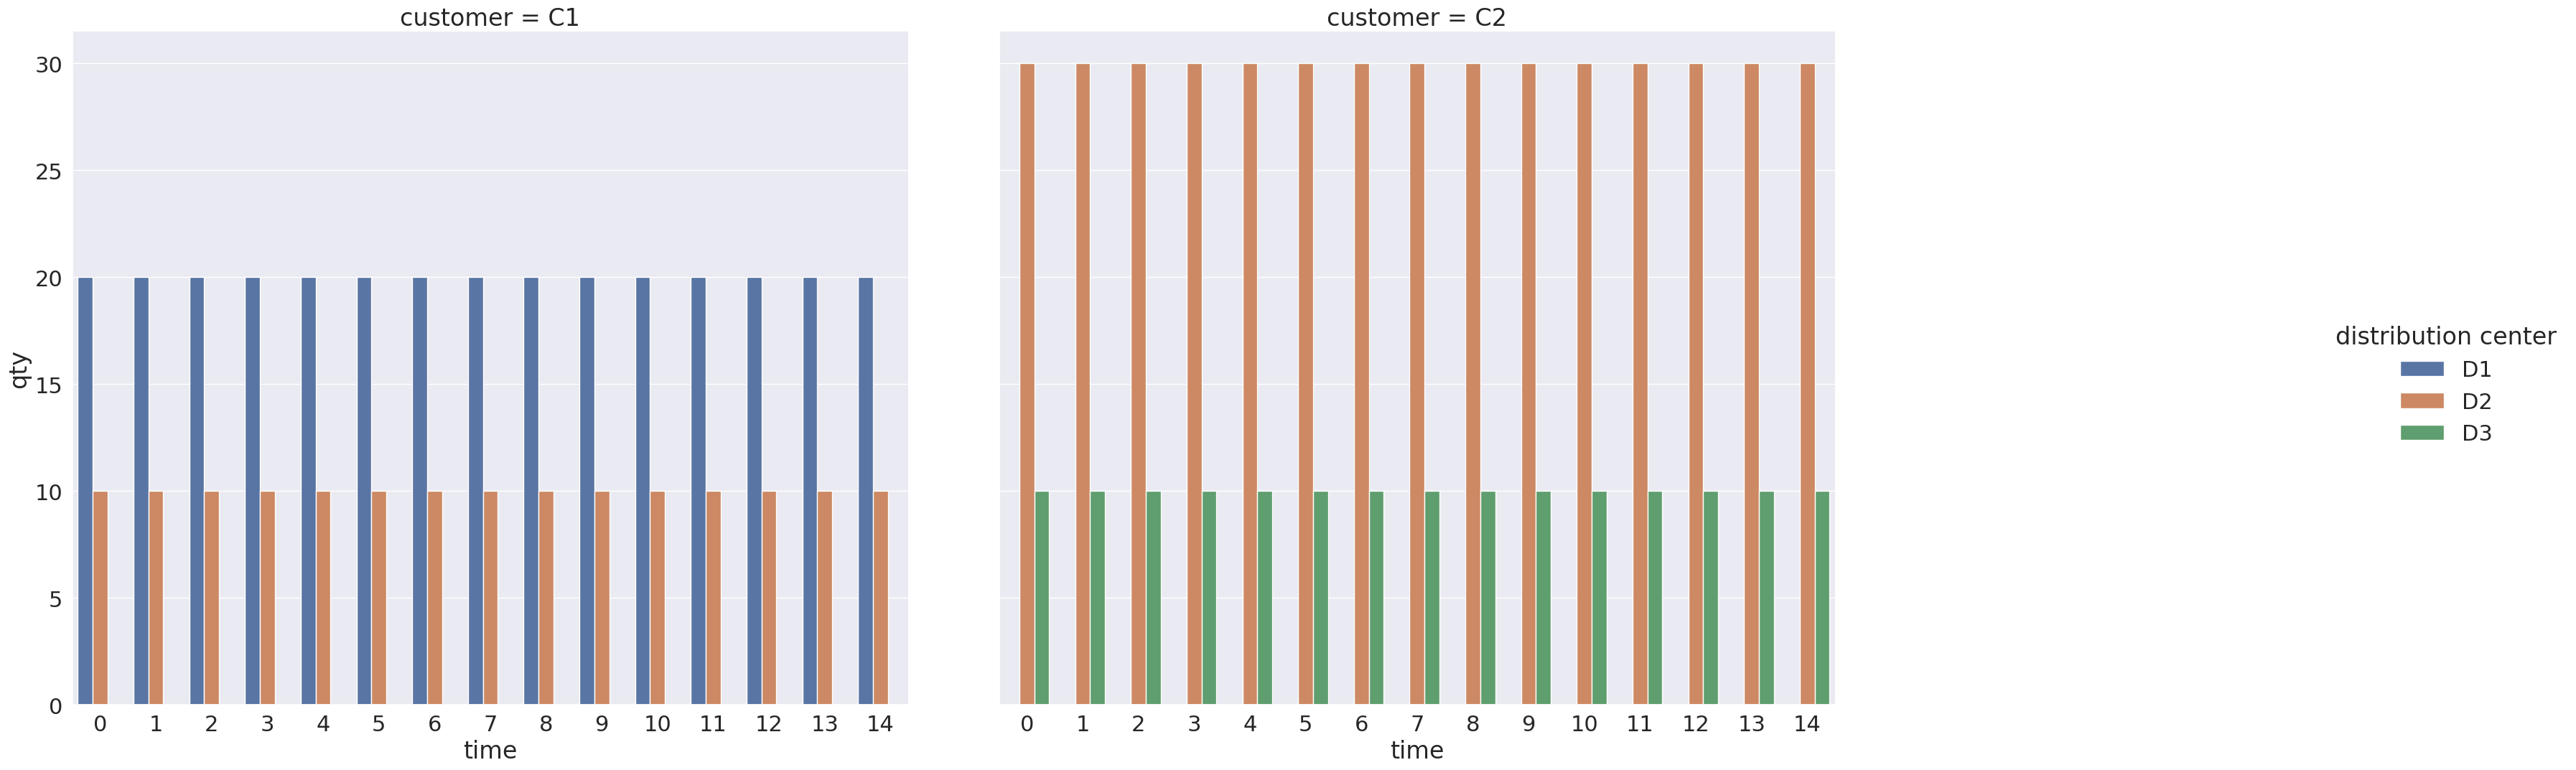

In [52]:
hm = sns.heatmap(df_capacity_utilization, annot=True)
hm.figure.set_size_inches(25,5)
sns.set(font_scale=2)
bc = sns.catplot(kind="bar", data=df_time_log, col="customer",x="time",y="qty",hue="distribution center")
bc.figure.set_size_inches(40,15)